### Import libraries 

In [11]:
import pandas as pd 
import numpy as np 
import scipy as sp 
import seaborn as sns 
import matplotlib.pyplot as plt 
import datetime as dt 

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from xgboost import XGBClassifier 
from xgboost import cv

from collections import Counter
import sys, os, glob

print(dt.datetime.now(), 'python version:')
print(sys.version)
print(dt.datetime.now(), 'pandas version:', pd.__version__)

2019-03-14 13:18:17.861596 python version:
3.6.7 (default, Dec  5 2018, 15:02:05) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-36)]
2019-03-14 13:18:17.862421 pandas version: 0.24.1


### Read data

In [73]:
print(dt.datetime.now(), 'start reading data...')

if os.path.isfile('../input/train.csv'): 
    print('remote environment')
    dirc = '../input/'
    train = pd.read_csv(dirc + 'train.csv')
    test = pd.read_csv(dirc + 'test.csv')
    submission = pd.read_csv(dirc + 'sample_submission.csv')
else: 
    print('local environment')
    dirc = '../../../data/Santander-Customer-Transaction-Prediction/'
    train = pd.read_csv(dirc + 'train.csv.zip', compression='zip')
    test = pd.read_csv(dirc + 'test.csv.zip', compression='zip')
    submission = pd.read_csv(dirc + 'sample_submission.csv.zip', compression='zip')


x = train.drop(['ID_code', 'target'], axis=1)
y = train.target

print('train shape', train.shape)
print('test shape', test.shape)

print(dt.datetime.now(), 'finish reading data')

test.drop('ID_code', axis=1, inplace=True) 

2019-03-14 14:49:29.231547 start reading data...
local environment
train shape (200000, 202)
test shape (200000, 201)
2019-03-14 14:49:50.469663 finish reading data


### Cross validation test

In [72]:
n_sp = 5 

sfk = StratifiedKFold(n_splits=n_sp)
pred_train_mtx = np.zeros(len(train))
pred_test_mtx = np.zeros((len(test), n_sp))

i = 0
for train_idx, val_idx in sfk.split(x, y): 
    train_x = x.iloc[train_idx, :] 
    val_x   = x.iloc[val_idx, :]
    train_y = y.iloc[train_idx] 
    val_y   = y.iloc[val_idx]
    
    print(dt.datetime.now(), 'cycle', i, 'start training...')  
    
    model = XGBClassifier(n_estimators=100000, n_jobs=32, tree_method='gpu_hist', 
                          learning_rate=0.01, 
                          max_delta_step=2, colsample_bylevel=0.6, colsample_bytree=0.1, 
                          gamma=0.004, max_bin=256, max_depth=8, max_leaves=27, min_child_weight=96, 
                          reg_alpha=0.003, reg_lambda=0.060, subsample=0.4) 

    #model = XGBClassifier(tree_method='gpu_hist')
    model.fit(train_x, train_y, eval_set=[(val_x, val_y)], 
              verbose=500,
              eval_metric='auc', early_stopping_rounds=200)#2500)
    
    pred_temp = model.predict_proba(val_x)[:, 1]
    print('roc_auc_score:', roc_auc_score(val_y, pred_temp))
    
    pred_train_mtx[val_idx] = pred_temp 
    pred_test_mtx[:, i] = model.predict_proba(test)[:, 1]
    
    print(dt.datetime.now(), 'finish cycle', i, 'training') 
    print()
    
    i += 1

print('final auc score:', roc_auc_score(y, pred_train_mtx))
pred = pred_test_mtx.mean(axis = 1)

2019-03-14 13:49:44.372957 cycle 0 start training...
[0]	validation_0-auc:0.620153
Will train until validation_0-auc hasn't improved in 200 rounds.
[500]	validation_0-auc:0.866979


KeyboardInterrupt: 

### Eval function versus training steps

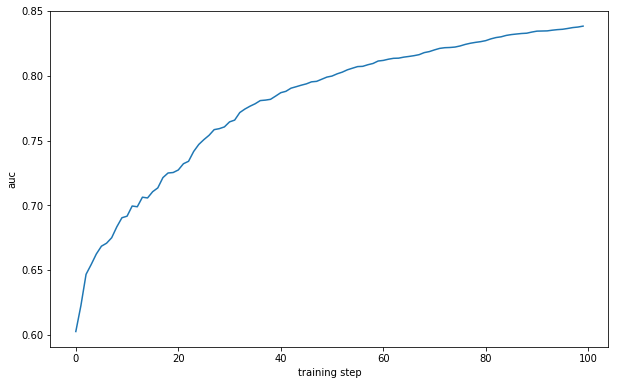

In [55]:
eval_auc = model.evals_result()['validation_0']['auc']

plt.figure(figsize=(10, 6.18))
plt.xlabel('training step')
plt.ylabel('auc')
sns.lineplot(x = range(len(eval_auc)), y = eval_auc)

### Receiver operating characteristic curve

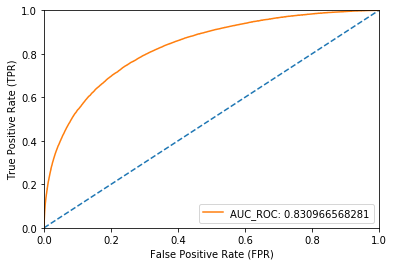

In [58]:
fpr, tpr, thresholds = roc_curve(y, pred_train_mtx)
score = roc_auc_score(y, pred_train_mtx)

plt.figure()
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(fpr, fpr, linestyle='--')
plt.plot(fpr, tpr, label='AUC_ROC: '+str(score))
plt.legend()
plt.show()

### Submit 

In [60]:
submission['target'] = pred
submission.to_csv('submission.csv', index=False)